In [1]:
import sys
%conda install --yes --prefix {sys.prefix} pymatreader

from pymatreader import read_mat
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import time


Note: you may need to restart the kernel to use updated packages.


In [2]:
data = read_mat('D:\\Dissertation\\wifimod\\S1_S47\\I3\\S1_S47_I3_T1.mat')

In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Raw_Cell_Matrix'])

In [4]:
df = pd.DataFrame(data['Raw_Cell_Matrix'])
# print(data['Raw_Cell_Matrix'])
df = df.drop(['Nrx', 'Ntx', 'noise','agc','RSSI_a', 'RSSI_b','RSSI_c', "timestamp_low"], axis=1)


In [5]:
def meanstd(df):
    test = df['CSI'].copy()
    test = test.dropna(axis=0)
    # print(df['CSI'])
    for i in range(0, len(test)):
        test[i] = test[i].flatten()
    test = test.to_numpy()
    # print(test.shape)
    test = np.column_stack(test) #Each array is the ith jth subcarrier of every sample
    # print(test.shape)
    # print(test[0])
    meanstd = [(np.mean(sample), np.std(sample)) for sample in test]
    # print([sample for sample in meanstd])
    # print(len(meanstd))
    return meanstd

def standardise(array): #Calculates the mean of each sample
    standardise = lambda x, y, z: (x-y)/z
    csistd = np.frompyfunc(standardise, 3, 1)
    mean = np.mean(array)
    std = np.std(array)
    return csistd(array,mean,std)

def standardise2(data,ms): #Calculates mean of each subcarrier
    # bySubcarrier = np.transpose(data)
    # print(data)
    # print('shape')
    data = np.array(data).flatten()
    # print(data.shape)
    
    combined = list(zip(ms, data))
    # print('combined')
    # print(combined[0])
    resultList = []
    for value in combined:
        standardise = lambda x, y, z: (x-y)/z
        csistd = np.frompyfunc(standardise, 3, 1)
        result = csistd(value[1],value[0][0],value[0][1])
        resultList.append(result)
    # return list(map(lambda x, y, z: (x-y)/z combined[1], combined[0][0], combined[0][1]))
    return resultList
    
def preprocess(df, active, steady):
    #Extracting the amplitude
    df['CSI'] = np.abs(df['CSI'])
    meanstdlist = meanstd(df)
    df['Standardised'] = [standardise2(sample, meanstdlist) for sample in df["CSI"]]
    
    # df.drop("CSI", inplace = True, axis = 1)
    
    
    
# preprocess(df, 'I1','I13')
preprocess(df, 'I1', 'I13')
df.dropna(axis=0)
print(df)
# print(df.shape)
# print(df.loc[0].shape)
# display(df['Standardised'].loc[0])
    

                                                    CSI label  \
0     [[[31.304951684997057, 31.016124838541646, 29....   I13   
1     [[[31.144823004794873, 30.265491900843113, 33....   I13   
2     [[[33.06055050963308, 35.35533905932738, 33.83...   I13   
3     [[[28.160255680657446, 33.12099032335839, 39.3...   I13   
4     [[[31.827660925679098, 36.359317925395686, 41....   I13   
...                                                 ...   ...   
1857  [[[31.400636936215164, 34.92849839314596, 36.1...    I3   
1858  [[[29.698484809834994, 36.6742416417845, 34.71...    I3   
1859  [[[31.064449134018133, 36.05551275463989, 37.1...    I3   
1860  [[[27.202941017470888, 36.22154055254967, 36.8...    I3   
1861  [[[28.861739379323623, 34.438350715445125, 39....    I3   

                                           Standardised  
0     [0.5374823278195023, -0.25505673458311706, -0....  
1     [0.5058107790211532, -0.3983976047854342, -0.0...  
2     [0.8847188988983274, 0.5735596385655605

In [8]:
check = df['Standardised']
type(check[0])

list

In [6]:
testpl = df['Standardised'].copy()
# testpl = df['CSI'].copy()
# testpl = [sample.flatten() for sample in testpl]
# testpl = np.transpose(testpl)
# print(testpl)
testpl = np.column_stack(testpl) #Each array is the ith jth subcarrier of every sample

print(testpl.shape)
print(testpl)
# print(test[0])

(180, 1862)
[[ 0.53748233  0.50581078  0.8847189  ...  0.48991378 -0.2738466
   0.05424399]
 [-0.25505673 -0.3983976   0.57355964 ...  0.70726481  0.73896948
   0.39845154]
 [-0.62612754 -0.07426538  0.04914954 ...  0.6005192   0.56406298
   0.92817731]
 ...
 [ 0.24725964 -0.4014153   0.42407816 ... -1.67884254 -1.31379812
  -1.85721011]
 [ 1.05288838  0.18329928  0.87623347 ... -0.70210533 -0.91643001
  -2.03045884]
 [ 1.41483099  0.60540958  0.45616876 ... -0.59904516 -0.43767459
  -1.91484187]]


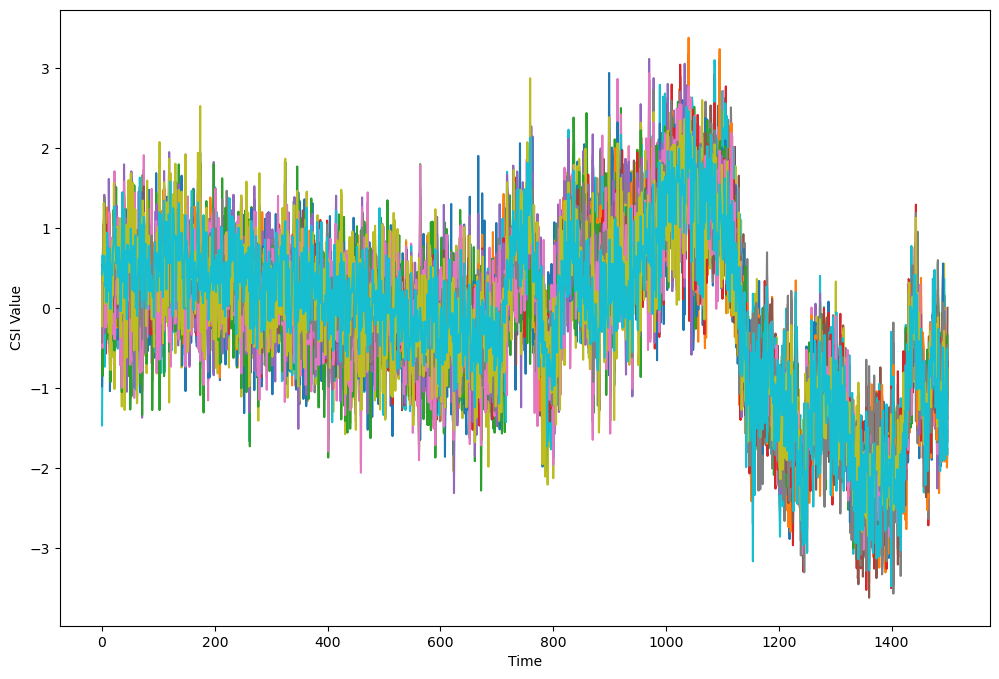

In [48]:
plt.figure(figsize=(12,8))
x = range(0,1500)
for i in range(20):
    y = testpl[i][0:1500]
    plt.plot(x, y)

plt.xlabel('Time')
plt.ylabel('CSI Value')
plt.show()

In [10]:
def segmentation(df):
    #Window size is 256, stride is 128
    segmented = pd.DataFrame({'Range': 'string', 'Sample': []})
    stride = 128
    startIndex = 0
    lastIndex = 256
    while(lastIndex < df.shape[0]):
        sample = df['Standardised']
        sample = sample.iloc[startIndex:lastIndex].to_numpy()
        index = '{}-{}'.format(startIndex, lastIndex)
        newRow = pd.Series({'Range' : index, 'Sample' : sample})
        segmented = pd.concat([segmented, newRow.to_frame().T], ignore_index=True)
        startIndex += stride
        lastIndex += stride

    return segmented
    
preprocessed = pd.DataFrame({'Range': '', 'Sample': [], 'Label': ''})

int1 = df.loc[df["label"] == "I3"]
int13 = df.loc[df["label"] == "I13"]

# int('Grouped')
segmentF = segmentation(int1)
segmentF['Label'] = ["I3" for sample in segmentF['Range']]
print(segmentF)
segmentS = segmentation(int13)
segmentS['Label'] = ["I13" for sample in segmentS['Range']]

preprocessed = pd.concat([preprocessed, segmentF], ignore_index=True)
preprocessed = pd.concat([preprocessed, segmentS], ignore_index=True)
print(preprocessed)
test = preprocessed['Sample']
print(type(test[0]))


      Range                                             Sample Label
0     0-256  [[0.5909553562024562, -0.8173933048063324, -1....    I3
1   128-384  [[0.2958379157748341, 0.791490095230002, 0.891...    I3
2   256-512  [[0.4515921287825665, 0.7231353533724645, 0.56...    I3
3   384-640  [[0.7852494161789686, 2.084296997125851, 1.264...    I3
4   512-768  [[-1.0199413229166137, 0.07731944263708668, -0...    I3
5   640-896  [[-1.2626561532342118, -0.5615938516118507, -1...    I3
6  768-1024  [[-2.4345077206309913, -2.4701234843192896, -2...    I3
7  896-1152  [[0.36122562383517376, 0.056882277663255765, 1...    I3
       Range                                             Sample Label
0      0-256  [[0.5909553562024562, -0.8173933048063324, -1....    I3
1    128-384  [[0.2958379157748341, 0.791490095230002, 0.891...    I3
2    256-512  [[0.4515921287825665, 0.7231353533724645, 0.56...    I3
3    384-640  [[0.7852494161789686, 2.084296997125851, 1.264...    I3
4    512-768  [[-1.0199413229